<a href="https://colab.research.google.com/github/LAMECH9/LAMECH9/blob/main/Deep_Q_Network_(DQN)_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Set Up Google Colab Environment

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

# Check if running in Colab and mount Google Drive
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    !pip install gym[classic_control]  # Install OpenAI Gym

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Purpose:

Imports necessary libraries (numpy, tensorflow, gym).

Checks if running in Colab and mounts Google Drive for saving models.

Installs gym[classic_control] for the CartPole environment.

# Step 2: Define the DQN Agent

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Replay memory
        self.gamma = 0.95    # Discount factor
        self.epsilon = 1.0    # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()  # Main model
        self.target_model = self._build_model()  # Target model
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:  # Exploration
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)  # Exploitation
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([t[0][0] for t in minibatch])
        actions = np.array([t[1] for t in minibatch])
        rewards = np.array([t[2] for t in minibatch])
        next_states = np.array([t[3][0] for t in minibatch])
        dones = np.array([t[4] for t in minibatch])

        # Compute target Q-values
        target_q = self.target_model.predict(next_states, verbose=0)
        max_target_q = np.amax(target_q, axis=1)
        current_q = self.model.predict(states, verbose=0)

        for i in range(batch_size):
            if dones[i]:
                current_q[i][actions[i]] = rewards[i]
            else:
                current_q[i][actions[i]] = rewards[i] + self.gamma * max_target_q[i]

        # Train the model
        self.model.fit(states, current_q, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

Key Components:

Replay Memory (deque) → Stores past experiences for training.

Two Neural Networks → model (main) and target_model (for stable Q-learning).

Epsilon-Greedy Policy → Balances exploration & exploitation.

Experience Replay → Samples past experiences to train the model.

# Step 3: Initialize Environment & Agent

In [4]:
env = gym.make('CartPole-v1')  # CartPole environment
state_size = env.observation_space.shape[0]  # 4 states (position, velocity, angle, angular velocity)
action_size = env.action_space.n  # 2 actions (left or right)
agent = DQNAgent(state_size, action_size)  # Initialize DQN agent

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CartPole Environment:

State: [cart_position, cart_velocity, pole_angle, pole_angular_velocity]

Action: 0 (push left) or 1 (push right).

# Step 4: Training Loop

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

# ... (rest of the code) ...

def preprocess_state(state):
    """Preprocesses the state for the neural network"""
    # Check if state is already a NumPy array and has the correct shape
    if isinstance(state, np.ndarray) and state.shape == (state_size,):
        return np.reshape(state, [1, state_size])  # Reshape if necessary
    # If state is not a NumPy array or has the wrong shape, try converting it
    try:
        state = np.array(state)
        if state.shape == (state_size,):
            return np.reshape(state, [1, state_size])  # Reshape if necessary
        else:
            # Handle cases where state has a different shape or is not convertible
            print("Warning: State has unexpected shape:", state.shape)
            return np.reshape(state, [1, state.shape[0]])  # Try reshaping based on actual shape
    except Exception as e:
        # Handle cases where state cannot be converted to a NumPy array
        print("Error: Could not convert state to NumPy array:", e)
        return np.reshape(np.array([state]), [1, 1])  # Reshape to (1, 1) as a fallback

# ... (rest of the code) ...

Training Process:

Interact with Environment → Agent takes actions (act()).

Store Experiences → Saves (state, action, reward, next_state, done) in memory.

Train via Replay → Samples past experiences (replay()).

Update Target Model → Syncs target_model periodically.

# Step 5: Plot Results & Save Model

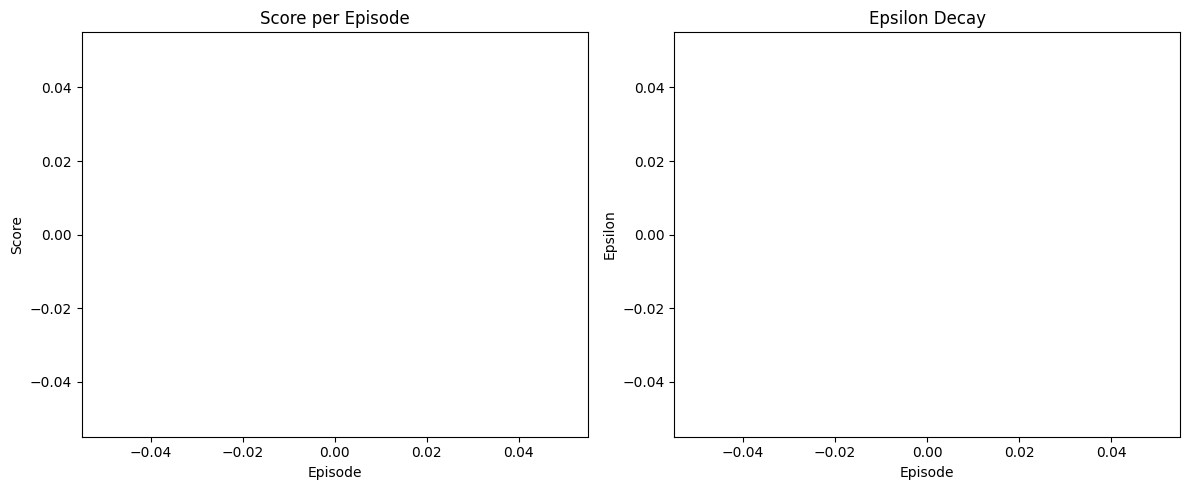

In [8]:
# Plot training progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(scores)
plt.title('Score per Episode')
plt.xlabel('Episode')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()

# Save model
# Save model
if IN_COLAB:
    agent.save('/content/drive/MyDrive/cartpole_dqn.weights.h5') # Added .weights to the filename
else:
    agent.save('cartpole_dqn.weights.h5') # Added .weights to the filename

Output:

Score Plot → Shows learning progress.

Epsilon Decay Plot → Shows exploration rate decreasing over time.

Model Saved → Weights stored in Google Drive (Colab) or locally.

# Step 6: Test the Trained Agent

In [ ]:
state = preprocess_state(env.reset()[0])
done = False
score = 0

while not done:
    env.render()  # Visualize
    action = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    state = preprocess_state(next_state)
    score += reward
    if done:
        print(f"Test Score: {score}")
        break

env.close()

Expected Result:

The agent should balance the pole for 200+ steps (max score in CartPole).

Set up Colab → Install dependencies.

Define DQN Agent → Neural networks, replay memory, epsilon-greedy policy.

Initialize Environment → CartPole-v1.

Train Agent → Interact, store experiences, replay training.

Plot & Save → Visualize performance, save model.

Test Agent → Run trained model.

This implementation includes Double DQN (separate target network) and Experience Replay for stable learning. 🚀